In [1]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG16, DenseNet121, InceptionV3, VGG19, Xception, MobileNetV2, EfficientNetB0
from tensorboard import notebook
from tensorflow import keras
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory
from tensorflow.keras.layers import ( Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout,
    Dense, Lambda, Reshape, Activation, Multiply, Add, UpSampling2D, LayerNormalization, Flatten, AveragePooling2D )
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf

2024-03-17 20:40:38.159576: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


100%|██████████| 405/405 [00:00<00:00, 522.47it/s]


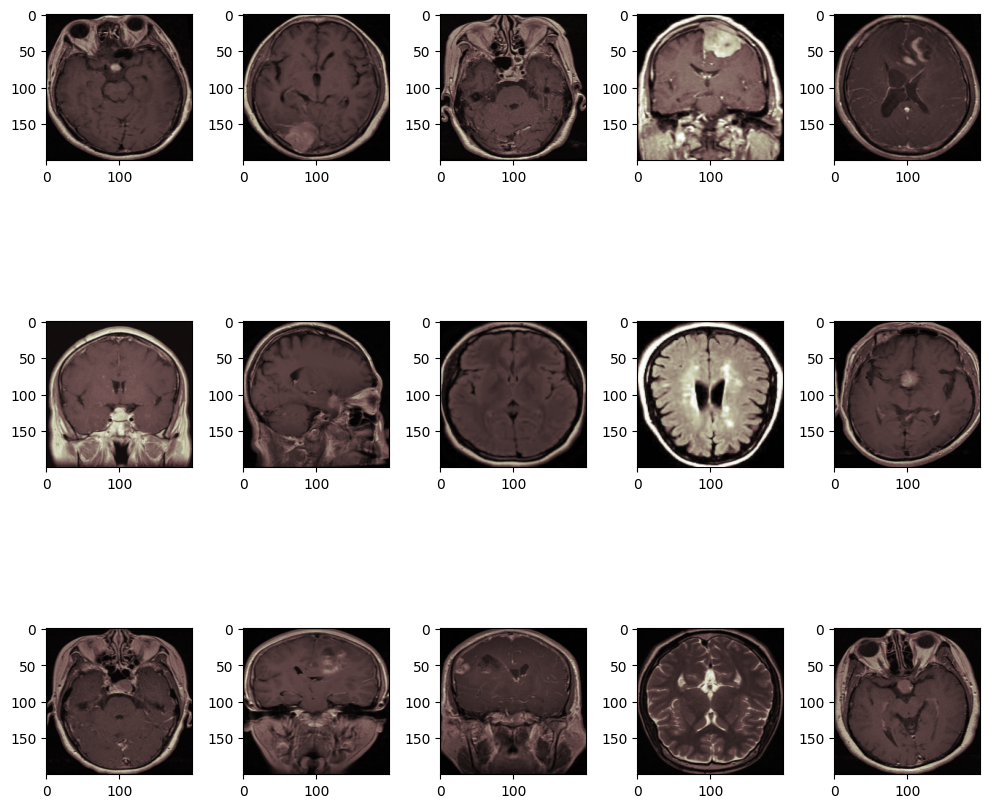

In [2]:
labels = ['glioma', 'meningioma', 'pituitary', 'notumor']
data_path = '/root/autodl-tmp/dataset/Br35H+SARTAJ+figshare/cropped'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

## Proposed

In [3]:
def block(inputs, filters):

    m = Conv2D(filters, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)

    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Concatenate()([m, a])

    d = Conv2D(filters * 2, 3, padding='same')(b)
    d = BatchNormalization()(d)
    d = ReLU()(d)

    d = Conv2D(filters * 2, 3, padding='same')(d)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    x = Concatenate()([b, d])

    m = Conv2D(filters*4, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)
    
    x = Add()([m, x])

    y = Conv2D(filters*2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y


def channel_attention(inputs, reduction=8):
    shape = K.int_shape(inputs)
    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // reduction, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    x = Multiply()([x, inputs])
    
    return x

def new_attention(inputs):

    b, h, w, c = inputs.shape.as_list()

    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    y = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(inputs)

    x = tf.reshape(x, [-1, 1, h*w])
    y = tf.reshape(y, [-1, 1, h*w])

    x = K.batch_dot(x, tf.reshape(inputs, [-1, h*w, c]))
    y = K.batch_dot(y, tf.reshape(inputs, [-1, h*w, c]))

    x = tf.reshape(x, [-1, 1, 1, c])
    y = tf.reshape(y, [-1, 1, 1, c])

    z = Multiply()([x, y])
    x = Activation('sigmoid')(z)

    y = channel_attention(inputs)
    x = Add()([x, y])
    
    x = Multiply()([x, inputs])

    return x


def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = block(x, 64)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = block(x, 128)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = block(x, 256)
    
    x = new_attention(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50
142/143 [============================>.] - ETA: 0s - loss: 0.7974 - accuracy: 0.6944
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 9.74 seconds
143/143 [==============================] - 10s 56ms/step - loss: 0.7978 - accuracy: 0.6944 - val_loss: 3.0886 - val_accuracy: 0.2587 - lr: 1.0000e-04
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.8319
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 7.43 seconds
143/143 [==============================] - 7s 52ms/step - loss: 0.4588 - accuracy: 0.8319 - val_loss: 2.4939 - val_accuracy: 0.2920 - lr: 1.0000e-04
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.8714
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 7.40 seconds
143/143 [==============================] - 7s 52ms/step - loss: 0.3419 - accuracy: 0.8714 - val_loss: 5.4614 - val_accuracy: 0.4493 - lr: 1.0000e-04
Epoch 4/50
143/143 [==============================] - ETA: 0s - loss: 0.2470 -

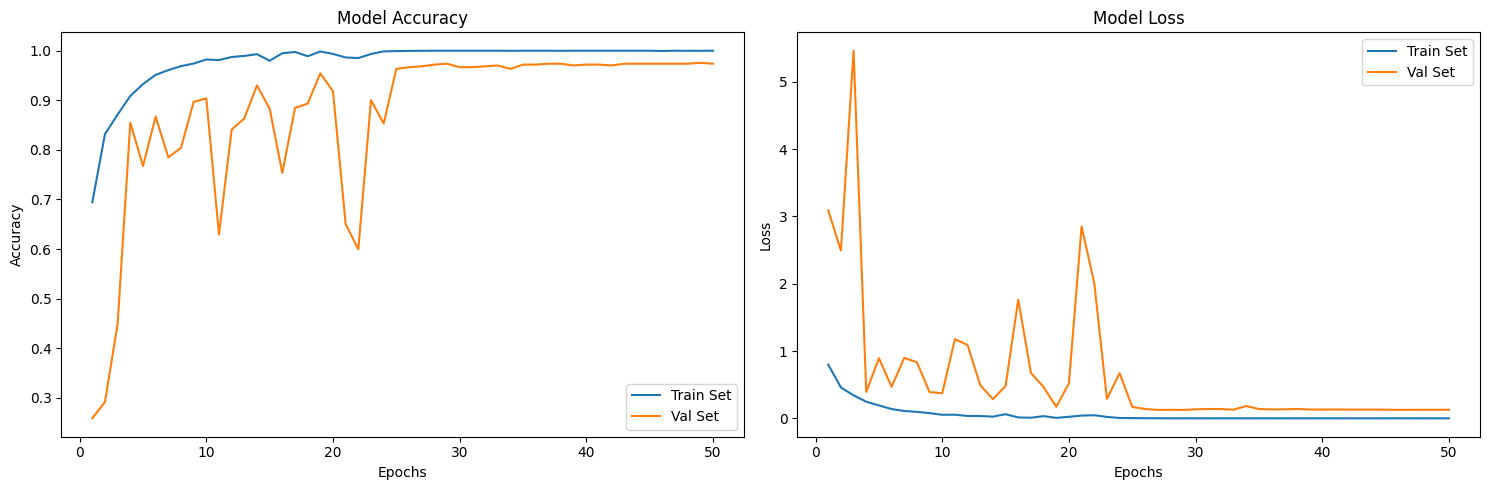

41/41 [==============================] - 1s 15ms/step - loss: 0.0804 - accuracy: 0.9817
Test Accuracy:  98.17
              precision    recall  f1-score   support

      glioma     1.0000    0.9633    0.9813       300
  meningioma     0.9608    0.9608    0.9608       306
   pituitary     0.9803    0.9967    0.9884       300
     notumor     0.9854    1.0000    0.9926       405

    accuracy                         0.9817      1311
   macro avg     0.9816    0.9802    0.9808      1311
weighted avg     0.9818    0.9817    0.9817      1311



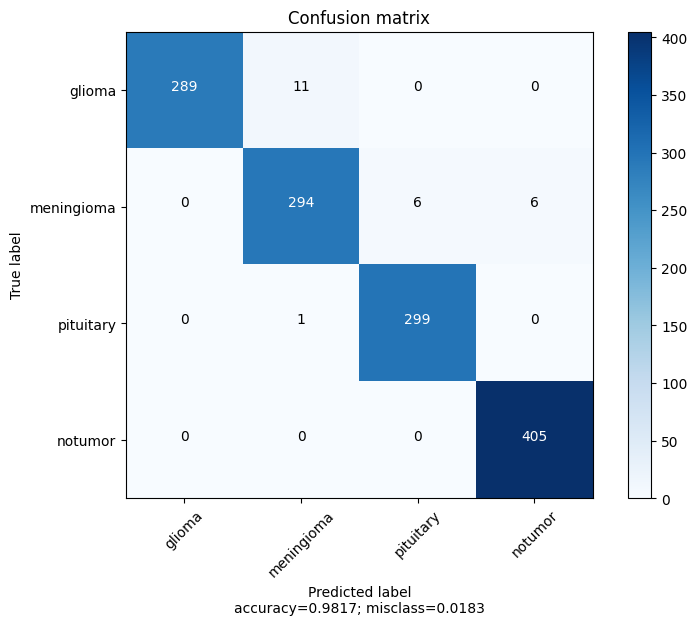

In [11]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='proposed.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## VGG16

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 1.1901 - accuracy: 0.4041
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 13.37 seconds
143/143 [==============================] - 13s 82ms/step - loss: 1.1901 - accuracy: 0.4041 - val_loss: 1.0392 - val_accuracy: 0.5140 - lr: 1.0000e-04
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.9900 - accuracy: 0.5391
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 10.32 seconds
143/143 [==============================] - 10s 72ms/step - loss: 0.9900 - accuracy: 0.5391 - val_loss: 0.9222 - val_accuracy: 0.5979 - lr: 1.0000e-04
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.8656 - accuracy: 0.6169
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 10.31 seconds
143/143 [==============================] - 10s 72ms/step - loss: 0.8656 - accuracy: 0.6169 - val_loss: 0.7426 - val_accuracy: 0.6941 - lr: 1.0000e-04
Epoch 4/50
143/143 [==============================] - ETA: 0s - loss: 0.7

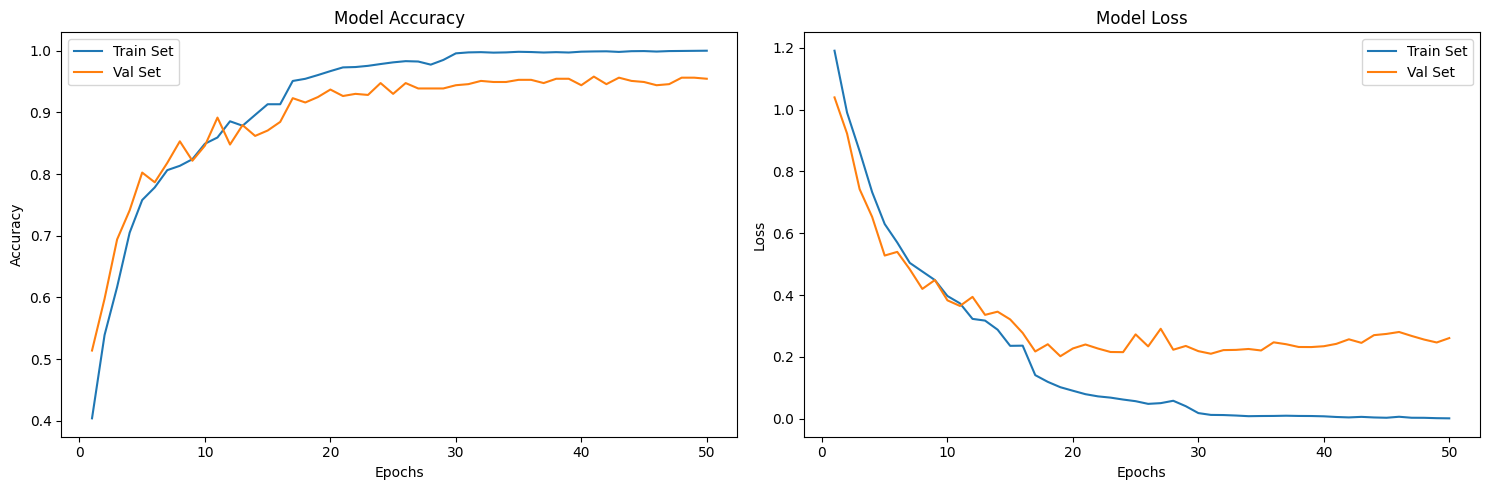

41/41 [==============================] - 1s 22ms/step - loss: 0.2155 - accuracy: 0.9634
Test Accuracy:  96.34
              precision    recall  f1-score   support

      glioma     0.9625    0.9400    0.9511       300
  meningioma     0.9398    0.9183    0.9289       306
   pituitary     0.9705    0.9867    0.9785       300
     notumor     0.9758    0.9975    0.9866       405

    accuracy                         0.9634      1311
   macro avg     0.9621    0.9606    0.9613      1311
weighted avg     0.9631    0.9634    0.9632      1311



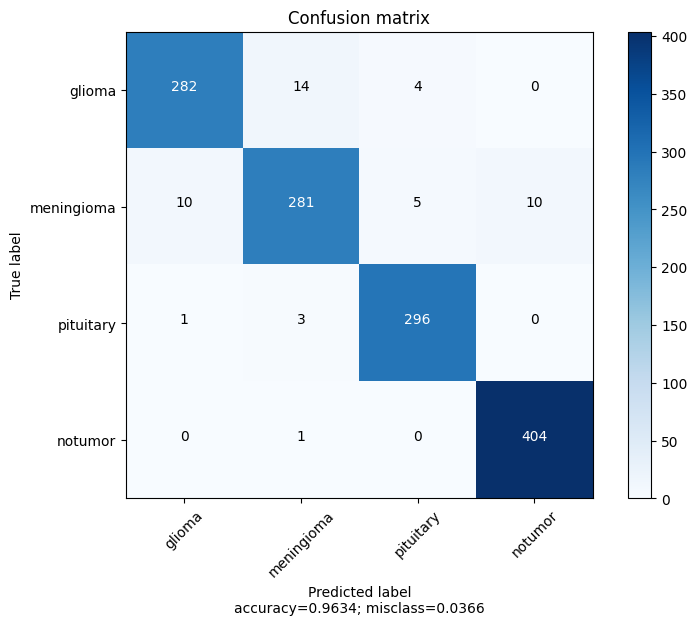

In [12]:
net = VGG16(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='VGG16.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)


## DenseNet121

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 0.7240 - accuracy: 0.7169
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 18.78 seconds
143/143 [==============================] - 19s 84ms/step - loss: 0.7240 - accuracy: 0.7169 - val_loss: 2.8025 - val_accuracy: 0.2465 - lr: 1.0000e-04
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.4066 - accuracy: 0.8502
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 10.50 seconds
143/143 [==============================] - 11s 74ms/step - loss: 0.4066 - accuracy: 0.8502 - val_loss: 4.4805 - val_accuracy: 0.2692 - lr: 1.0000e-04
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.8918
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 10.45 seconds
143/143 [==============================] - 10s 73ms/step - loss: 0.3007 - accuracy: 0.8918 - val_loss: 2.1638 - val_accuracy: 0.3741 - lr: 1.0000e-04
Epoch 4/50
143/143 [==============================] - ETA: 0s - loss: 0.2

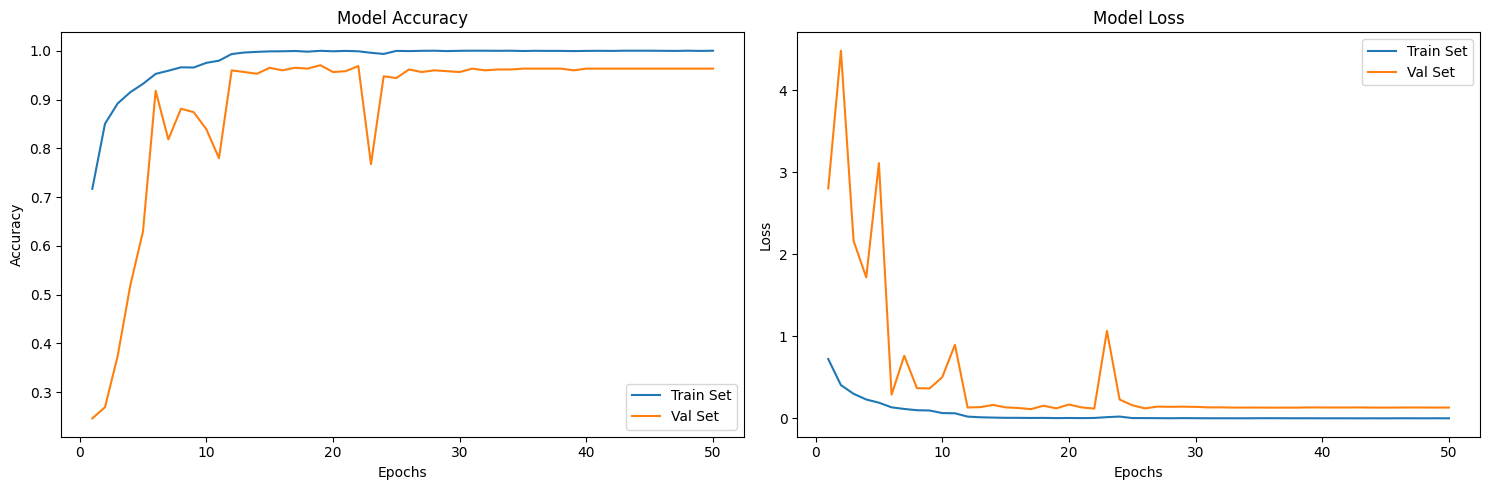

41/41 [==============================] - 1s 19ms/step - loss: 0.0921 - accuracy: 0.9748
Test Accuracy:  97.48
              precision    recall  f1-score   support

      glioma     0.9760    0.9500    0.9628       300
  meningioma     0.9515    0.9608    0.9561       306
   pituitary     0.9802    0.9900    0.9851       300
     notumor     0.9877    0.9926    0.9901       405

    accuracy                         0.9748      1311
   macro avg     0.9738    0.9733    0.9735      1311
weighted avg     0.9749    0.9748    0.9748      1311



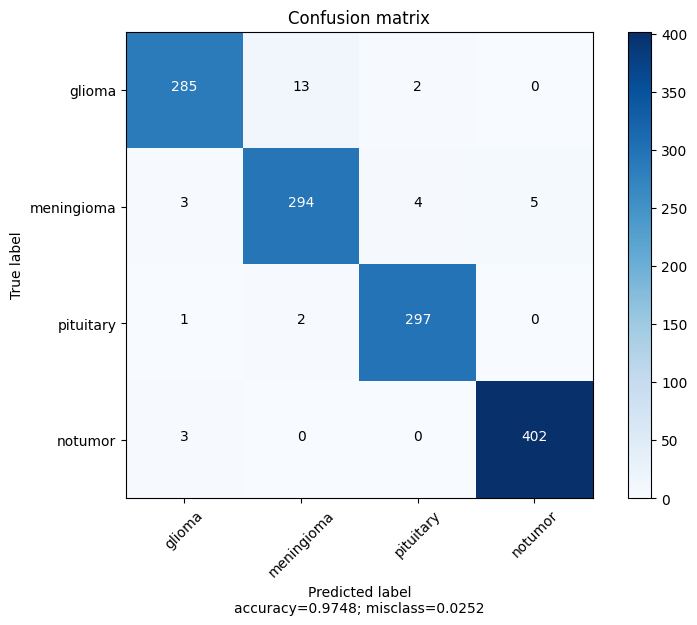

In [13]:
net = DenseNet121(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='DenseNet121.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## Xception

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 0.6449 - accuracy: 0.7516
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 24.58 seconds
143/143 [==============================] - 25s 149ms/step - loss: 0.6449 - accuracy: 0.7516 - val_loss: 1.3973 - val_accuracy: 0.2465 - lr: 1.0000e-04
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9121
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 19.70 seconds
143/143 [==============================] - 20s 138ms/step - loss: 0.2446 - accuracy: 0.9121 - val_loss: 1.4902 - val_accuracy: 0.2203 - lr: 1.0000e-04
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9728
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 19.99 seconds
143/143 [==============================] - 20s 140ms/step - loss: 0.0836 - accuracy: 0.9728 - val_loss: 2.2181 - val_accuracy: 0.2150 - lr: 1.0000e-04
Epoch 4/50
143/143 [==============================] - ETA: 0s - loss: 

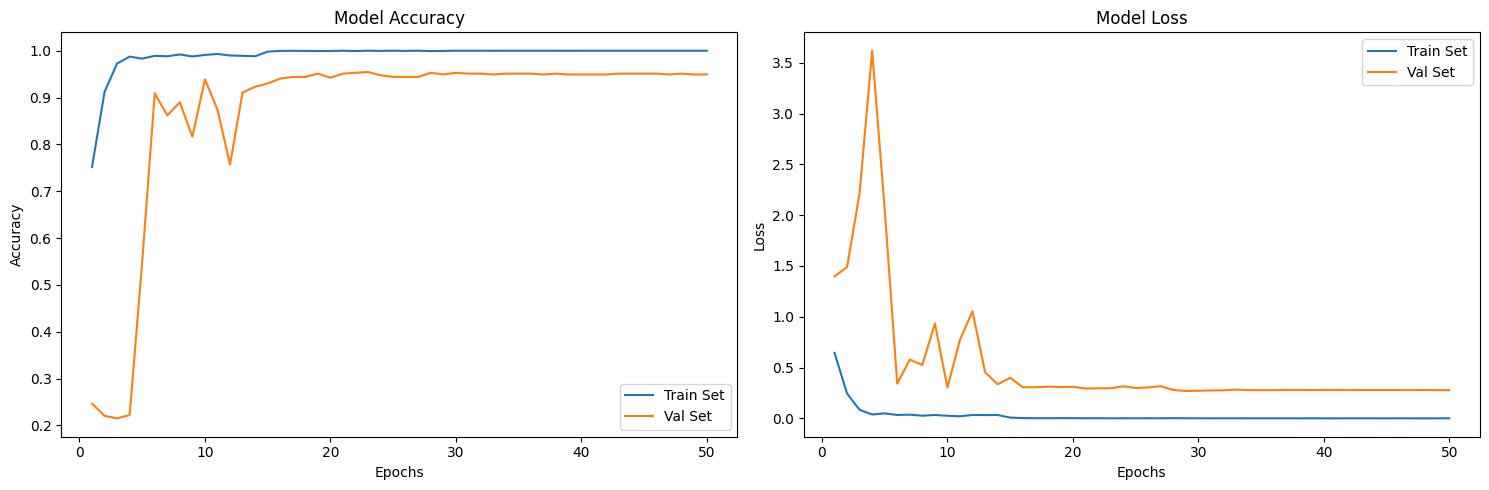

41/41 [==============================] - 1s 18ms/step - loss: 0.2205 - accuracy: 0.9558
Test Accuracy:  95.58
              precision    recall  f1-score   support

      glioma     0.9553    0.9267    0.9408       300
  meningioma     0.9264    0.9052    0.9157       306
   pituitary     0.9609    0.9833    0.9720       300
     notumor     0.9734    0.9951    0.9841       405

    accuracy                         0.9558      1311
   macro avg     0.9540    0.9526    0.9532      1311
weighted avg     0.9555    0.9558    0.9555      1311



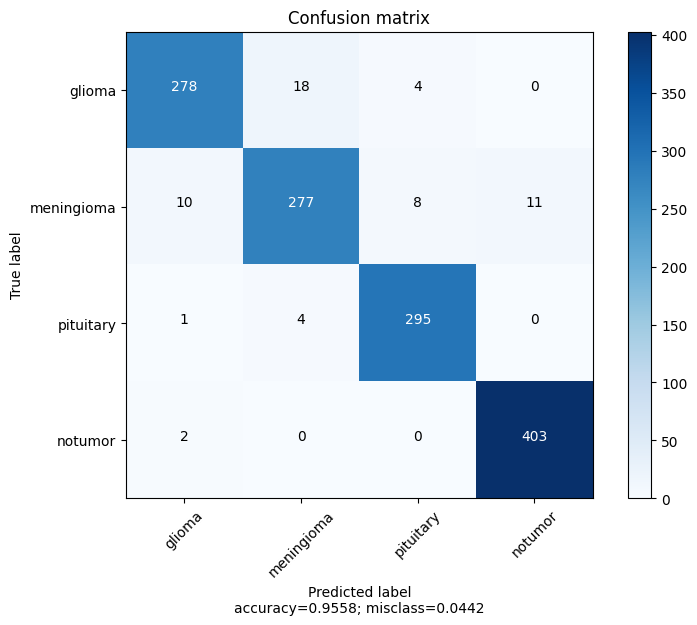

In [14]:
net = Xception(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='Xception.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## ResNet50

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 1.1515 - accuracy: 0.5553
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 13.45 seconds
143/143 [==============================] - 13s 66ms/step - loss: 1.1515 - accuracy: 0.5553 - val_loss: 3.1088 - val_accuracy: 0.2150 - lr: 1.0000e-04
Epoch 2/50
142/143 [============================>.] - ETA: 0s - loss: 0.7092 - accuracy: 0.7377
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 8.41 seconds
143/143 [==============================] - 8s 59ms/step - loss: 0.7076 - accuracy: 0.7385 - val_loss: 4.0207 - val_accuracy: 0.2920 - lr: 1.0000e-04
Epoch 3/50
142/143 [============================>.] - ETA: 0s - loss: 0.5585 - accuracy: 0.7969
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 8.44 seconds
143/143 [==============================] - 8s 59ms/step - loss: 0.5580 - accuracy: 0.7967 - val_loss: 2.9084 - val_accuracy: 0.3322 - lr: 1.0000e-04
Epoch 4/50
142/143 [============================>.] - ETA: 0s - loss: 0.4122 

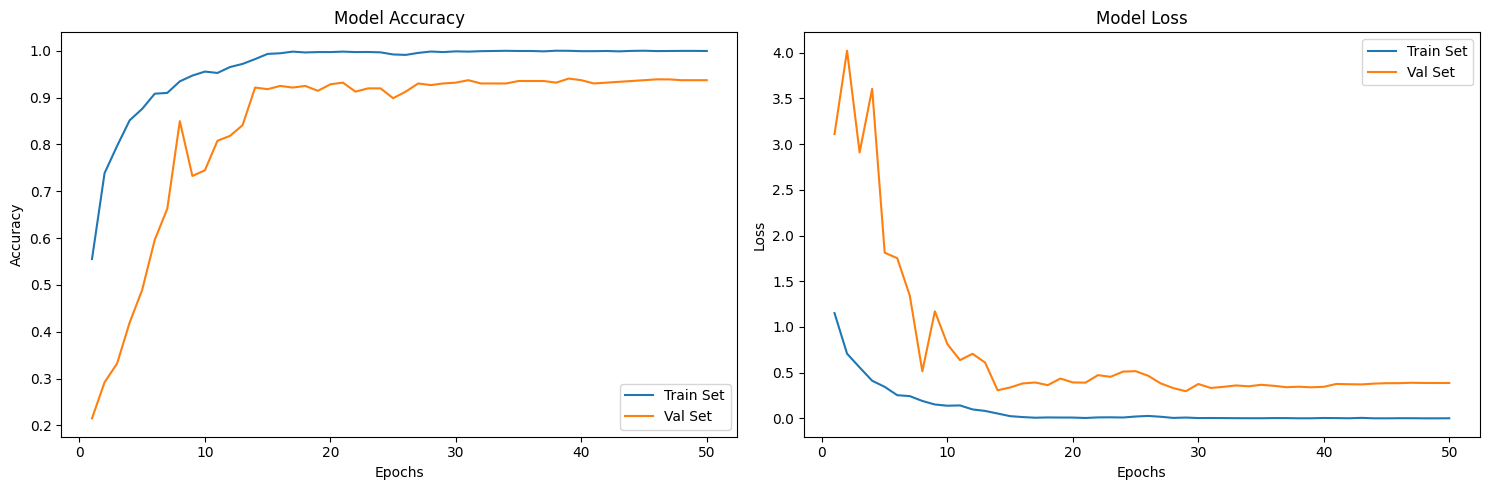

41/41 [==============================] - 1s 16ms/step - loss: 0.2468 - accuracy: 0.9497
Test Accuracy:  94.97
              precision    recall  f1-score   support

      glioma     0.9614    0.9133    0.9368       300
  meningioma     0.8942    0.9118    0.9029       306
   pituitary     0.9700    0.9700    0.9700       300
     notumor     0.9686    0.9901    0.9792       405

    accuracy                         0.9497      1311
   macro avg     0.9486    0.9463    0.9472      1311
weighted avg     0.9499    0.9497    0.9496      1311



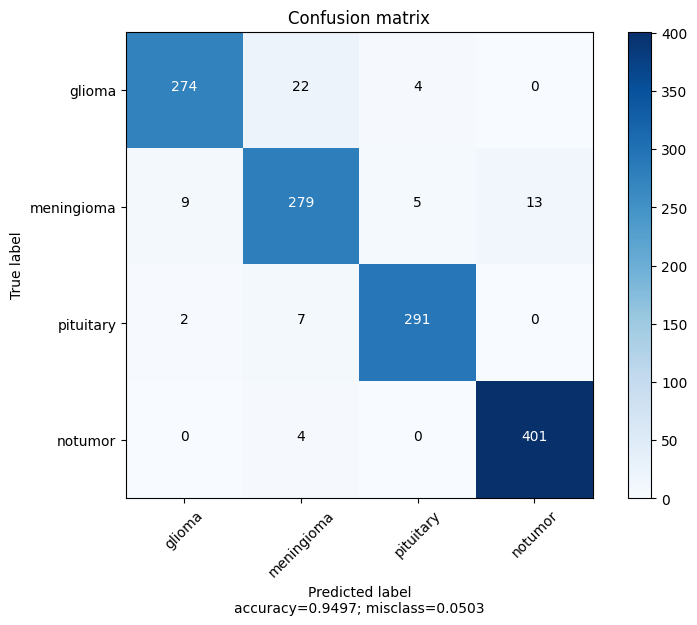

In [15]:
net = ResNet50(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='ResNet50.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## EfficientNetB0

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 1.1375 - accuracy: 0.4916
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 19.27 seconds
143/143 [==============================] - 19s 99ms/step - loss: 1.1375 - accuracy: 0.4916 - val_loss: 1.6027 - val_accuracy: 0.2150 - lr: 1.0000e-04
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.8744 - accuracy: 0.6337
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 13.16 seconds
143/143 [==============================] - 13s 92ms/step - loss: 0.8744 - accuracy: 0.6337 - val_loss: 2.2611 - val_accuracy: 0.2150 - lr: 1.0000e-04
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.7107 - accuracy: 0.7043
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 13.30 seconds
143/143 [==============================] - 13s 93ms/step - loss: 0.7107 - accuracy: 0.7043 - val_loss: 2.4467 - val_accuracy: 0.2150 - lr: 1.0000e-04
Epoch 4/50
143/143 [==============================] - ETA: 0s - loss: 0.5

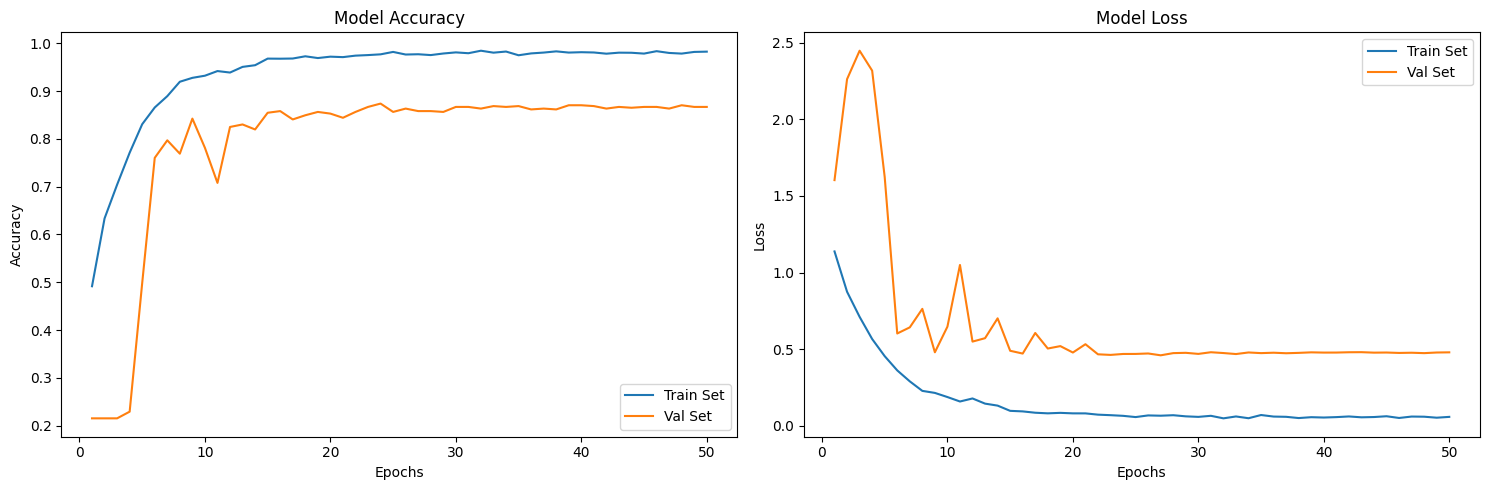

41/41 [==============================] - 1s 12ms/step - loss: 0.4709 - accuracy: 0.8802
Test Accuracy:  88.02
              precision    recall  f1-score   support

      glioma     0.8007    0.8167    0.8086       300
  meningioma     0.8133    0.7974    0.8053       306
   pituitary     0.9075    0.8833    0.8953       300
     notumor     0.9685    0.9877    0.9780       405

    accuracy                         0.8802      1311
   macro avg     0.8725    0.8713    0.8718      1311
weighted avg     0.8799    0.8802    0.8800      1311



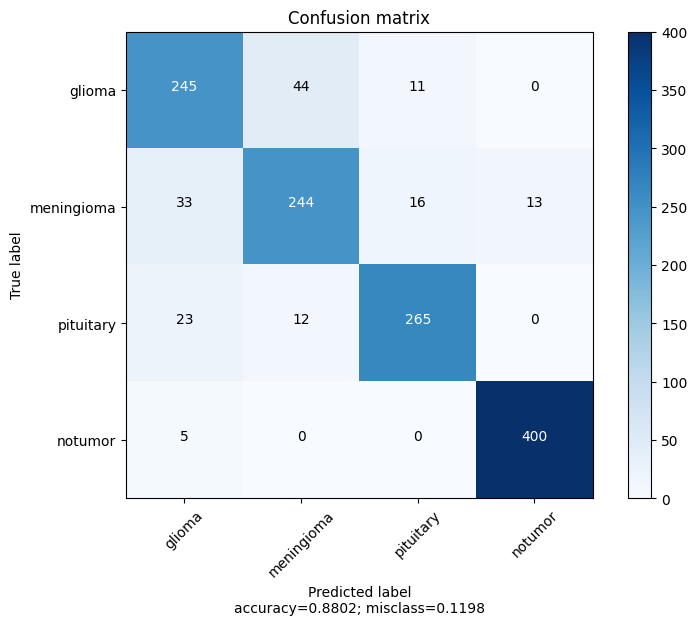

In [17]:
net = EfficientNetB0(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='EfficientNetB0.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## InceptionV3

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 0.7687 - accuracy: 0.6883
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 14.50 seconds
143/143 [==============================] - 14s 66ms/step - loss: 0.7687 - accuracy: 0.6883 - val_loss: 2.6504 - val_accuracy: 0.2150 - lr: 1.0000e-04
Epoch 2/50
142/143 [============================>.] - ETA: 0s - loss: 0.5147 - accuracy: 0.8099
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 7.66 seconds
143/143 [==============================] - 8s 54ms/step - loss: 0.5166 - accuracy: 0.8093 - val_loss: 2.1437 - val_accuracy: 0.3951 - lr: 1.0000e-04
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.4059 - accuracy: 0.8512
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 7.52 seconds
143/143 [==============================] - 8s 53ms/step - loss: 0.4059 - accuracy: 0.8512 - val_loss: 2.0371 - val_accuracy: 0.3304 - lr: 1.0000e-04
Epoch 4/50
142/143 [============================>.] - ETA: 0s - loss: 0.3334 

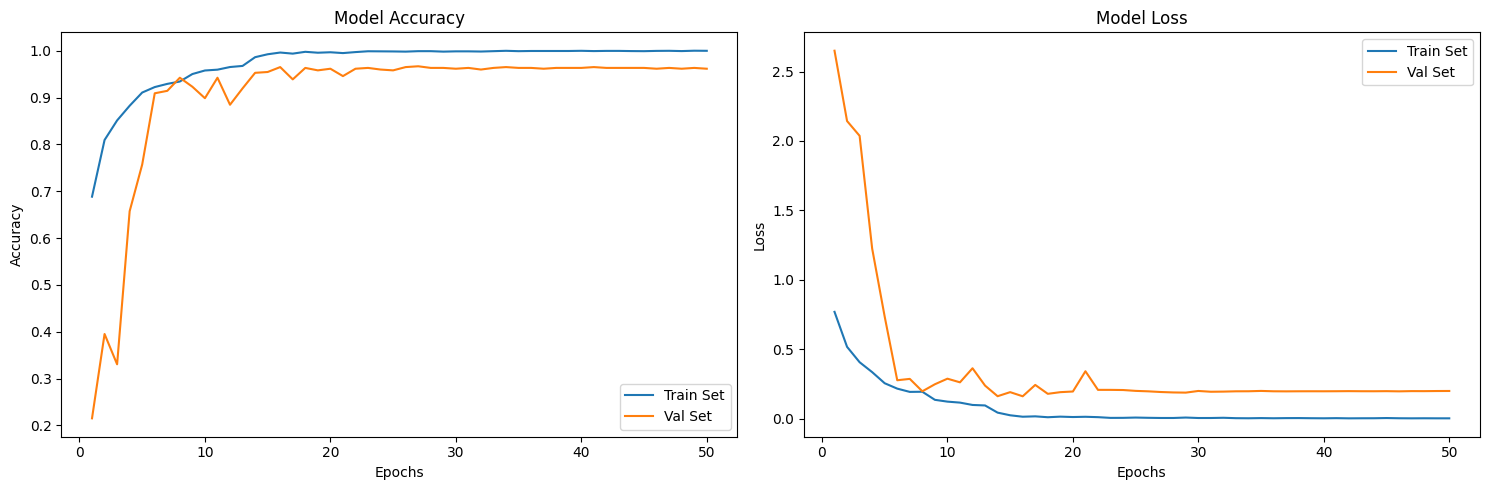

41/41 [==============================] - 1s 16ms/step - loss: 0.0935 - accuracy: 0.9741
Test Accuracy:  97.41
              precision    recall  f1-score   support

      glioma     0.9761    0.9533    0.9646       300
  meningioma     0.9479    0.9510    0.9494       306
   pituitary     0.9867    0.9867    0.9867       300
     notumor     0.9830    0.9975    0.9902       405

    accuracy                         0.9741      1311
   macro avg     0.9734    0.9721    0.9727      1311
weighted avg     0.9741    0.9741    0.9740      1311



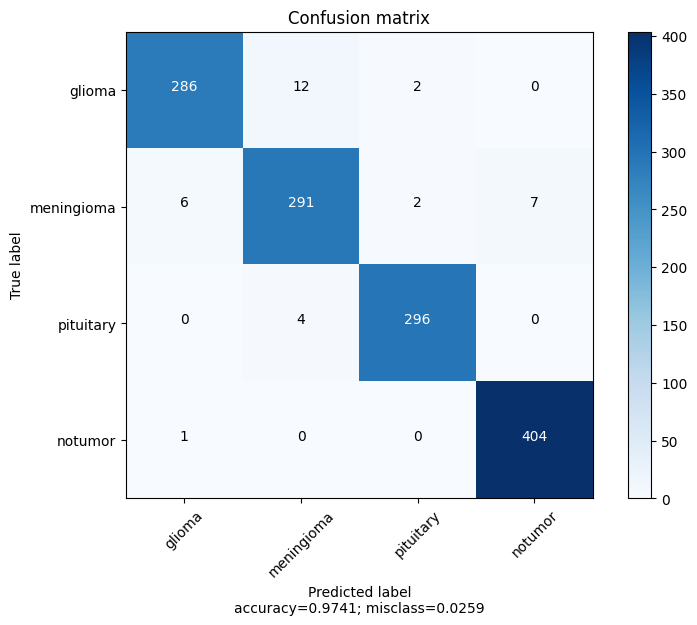

In [18]:
net = InceptionV3(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='InceptionV3.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## SqueezeNet

In [20]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
import warnings
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.utils import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"


def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=4):
    
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

   
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')


    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 1.2808 - accuracy: 0.3274
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 3.70 seconds
143/143 [==============================] - 4s 18ms/step - loss: 1.2808 - accuracy: 0.3274 - val_loss: 1.1050 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 1.0607 - accuracy: 0.5029
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 1.93 seconds
143/143 [==============================] - 2s 13ms/step - loss: 1.0607 - accuracy: 0.5029 - val_loss: 1.0224 - val_accuracy: 0.5140 - lr: 1.0000e-04
Epoch 3/50
142/143 [============================>.] - ETA: 0s - loss: 1.0262 - accuracy: 0.5225
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 2.11 seconds
143/143 [==============================] - 2s 15ms/step - loss: 1.0279 - accuracy: 0.5218 - val_loss: 1.0242 - val_accuracy: 0.5245 - lr: 1.0000e-04
Epoch 4/50
141/143 [============================>.] - ETA: 0s - loss: 1.0070 - 

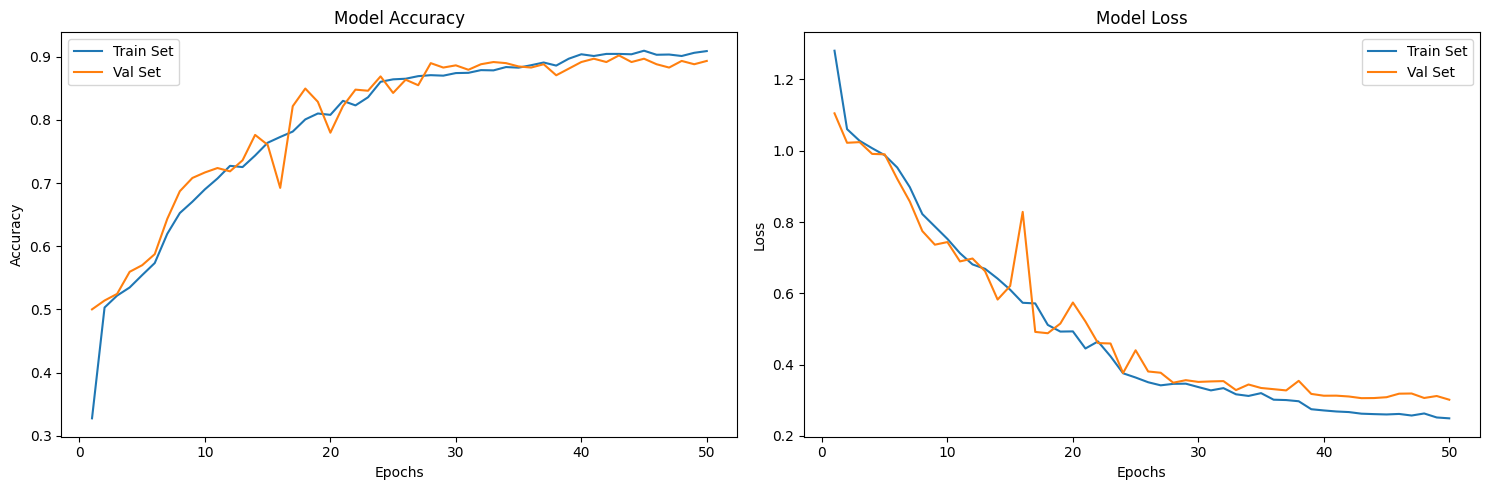

41/41 [==============================] - 0s 5ms/step - loss: 0.3627 - accuracy: 0.8604
Test Accuracy:  86.04
              precision    recall  f1-score   support

      glioma     0.9080    0.7900    0.8449       300
  meningioma     0.7379    0.6993    0.7181       306
   pituitary     0.9156    0.9400    0.9276       300
     notumor     0.8739    0.9753    0.9218       405

    accuracy                         0.8604      1311
   macro avg     0.8589    0.8512    0.8531      1311
weighted avg     0.8595    0.8604    0.8580      1311



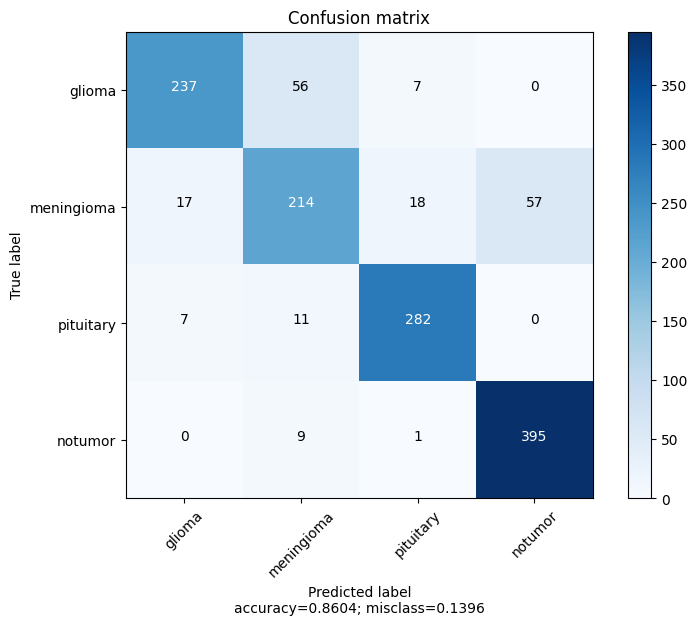

In [21]:
net = SqueezeNet(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='SqueezeNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## MobileNetV2

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 1.2240 - accuracy: 0.5074
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 13.17 seconds
143/143 [==============================] - 13s 74ms/step - loss: 1.2240 - accuracy: 0.5074 - val_loss: 7.9404 - val_accuracy: 0.2762 - lr: 0.0100
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.8612 - accuracy: 0.6593
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 10.00 seconds
143/143 [==============================] - 10s 70ms/step - loss: 0.8612 - accuracy: 0.6593 - val_loss: 1.4104 - val_accuracy: 0.2885 - lr: 0.0100
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.7367 - accuracy: 0.7183
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 10.01 seconds
143/143 [==============================] - 10s 70ms/step - loss: 0.7367 - accuracy: 0.7183 - val_loss: 4.5269 - val_accuracy: 0.2587 - lr: 0.0100
Epoch 4/50
143/143 [==============================] - ETA: 0s - loss: 0.6497 - accura

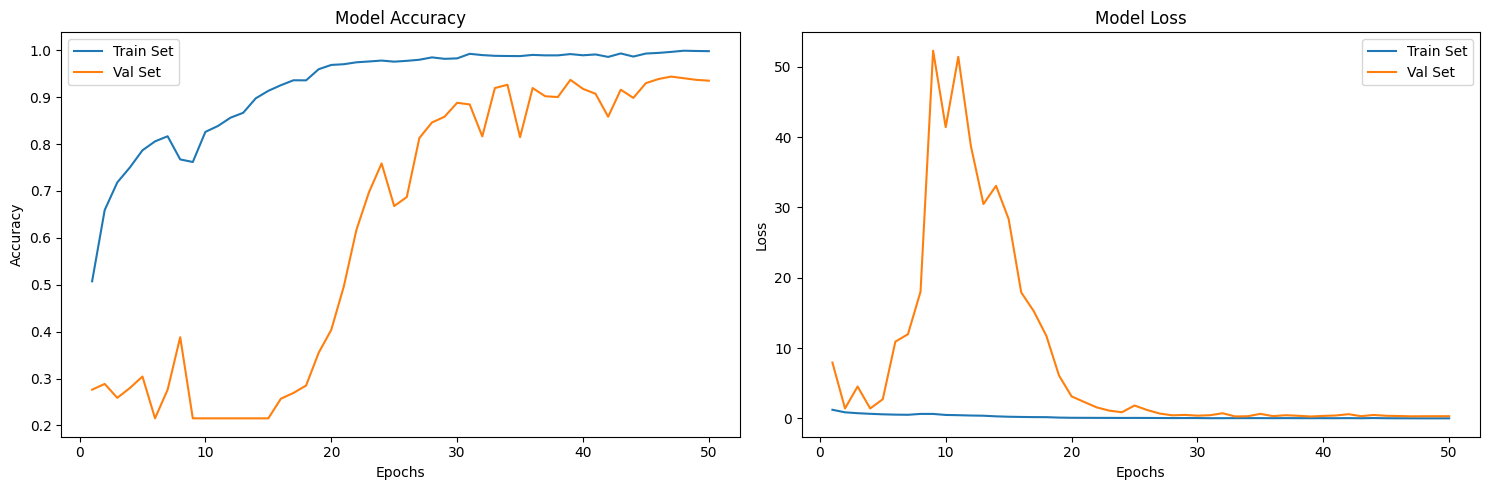

41/41 [==============================] - 0s 9ms/step - loss: 0.3244 - accuracy: 0.9252
Test Accuracy:  92.52
              precision    recall  f1-score   support

      glioma     0.9567    0.8100    0.8773       300
  meningioma     0.8714    0.8856    0.8784       306
   pituitary     0.8839    0.9900    0.9340       300
     notumor     0.9805    0.9926    0.9865       405

    accuracy                         0.9252      1311
   macro avg     0.9231    0.9196    0.9190      1311
weighted avg     0.9275    0.9252    0.9243      1311



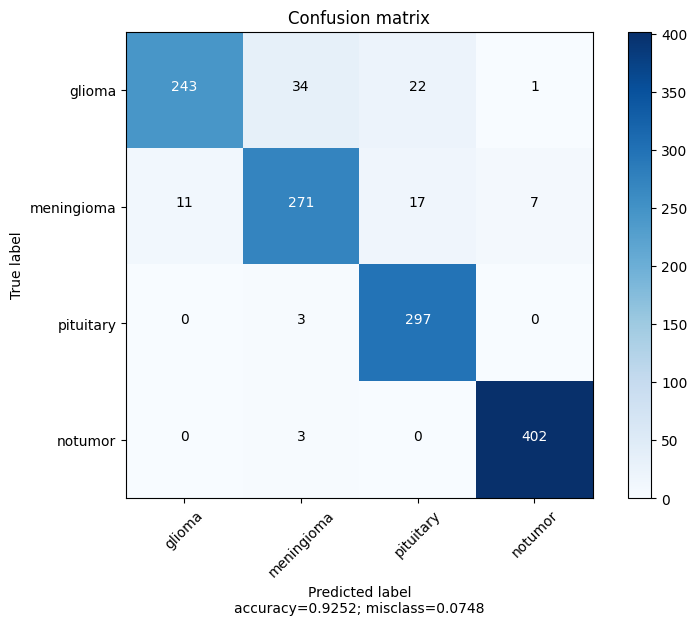

In [6]:
net = MobileNetV2(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='MobileNetV2.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## AlexNet

In [4]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, Conv2D, BatchNormalization, MaxPool2D, Flatten
import warnings
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.utils import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils

alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))

Epoch 1/50


2024-03-17 20:42:57.109219: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2024-03-17 20:42:57.857725: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-17 20:42:57.857743: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-03-17 20:42:57.857796: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-17 20:42:58.346511: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 70/143 [=============>................] - ETA: 0s - loss: 1.5035 - accuracy: 0.4190

143/143 [==============================] - ETA: 0s - loss: 1.3300 - accuracy: 0.4589
Epoch 1: saving model to model-AlexNet.h5
Epoch 1: 5.48 seconds
143/143 [==============================] - 5s 14ms/step - loss: 1.3300 - accuracy: 0.4589 - val_loss: 1.4760 - val_accuracy: 0.2168 - lr: 1.0000e-04
Epoch 2/50
142/143 [============================>.] - ETA: 0s - loss: 1.0071 - accuracy: 0.5685
Epoch 2: saving model to model-AlexNet.h5
Epoch 2: 1.29 seconds
143/143 [==============================] - 1s 9ms/step - loss: 1.0080 - accuracy: 0.5679 - val_loss: 1.4104 - val_accuracy: 0.3287 - lr: 1.0000e-04
Epoch 3/50
142/143 [============================>.] - ETA: 0s - loss: 0.8672 - accuracy: 0.6610
Epoch 3: saving model to model-AlexNet.h5
Epoch 3: 1.25 seconds
143/143 [==============================] - 1s 9ms/step - loss: 0.8678 - accuracy: 0.6605 - val_loss: 1.7719 - val_accuracy: 0.4528 - lr: 1.0000e-04
Epoch 4/50
138/143 [===========================>..] - ETA: 0s - loss: 0.7690 - accurac

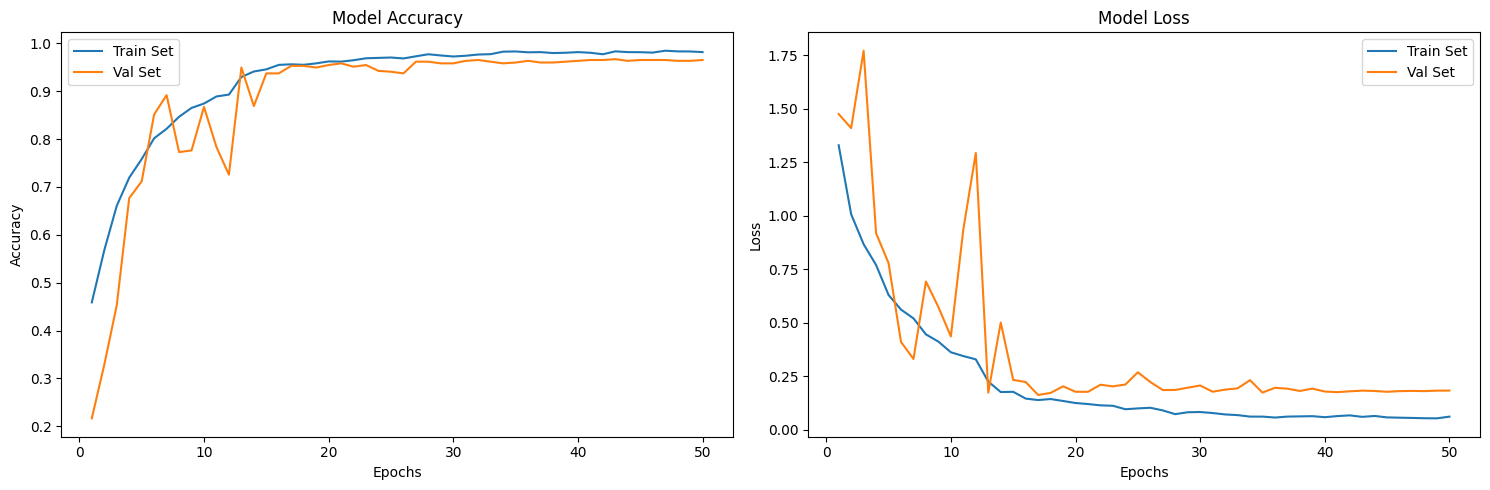

41/41 [==============================] - 0s 4ms/step - loss: 0.1085 - accuracy: 0.9718
Test Accuracy:  97.18
              precision    recall  f1-score   support

      glioma     0.9797    0.9633    0.9714       300
  meningioma     0.9533    0.9346    0.9439       306
   pituitary     0.9739    0.9933    0.9835       300
     notumor     0.9780    0.9901    0.9840       405

    accuracy                         0.9718      1311
   macro avg     0.9712    0.9704    0.9707      1311
weighted avg     0.9717    0.9718    0.9717      1311



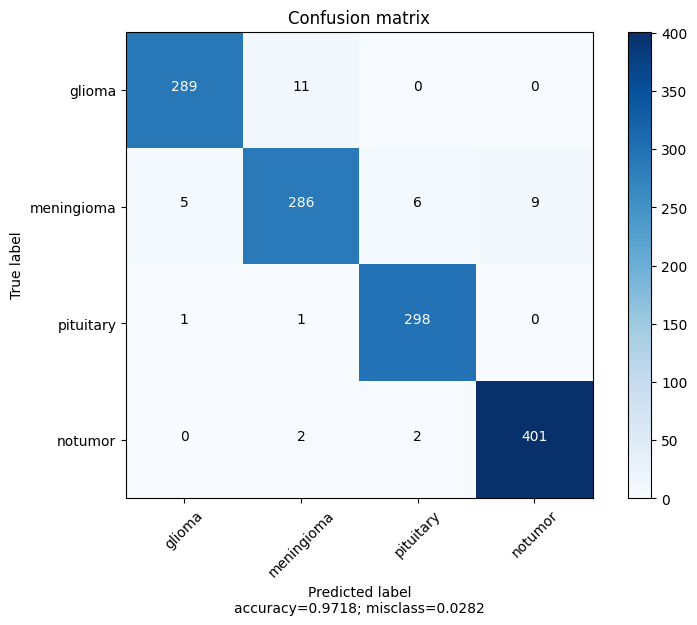

In [5]:
net = alexnet_cnn
adam = keras.optimizers.Adam(learning_rate=0.0001)
net.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='AlexNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = net.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = net.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = net.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)